[View in Colaboratory](https://colab.research.google.com/github/rdenadai/DSP-Study-Notebooks/blob/master/notebooks/dsp101c.ipynb)

## DSP 101c


Experiments on Digital Signal Processing, ranging from random generated signals, voice and images!

In these experiments, we are not analysing signals in the range of DSP but also with an statistical view...

To build this document we use a lot of resources, here are some of the most important.
- References:
 - [DSP Guide](http://www.dspguide.com)
 - [Understand the Fourier transform and its applications](https://www.udemy.com/fourier-transform-mxc/)
 - [MikeXCohen Lectures](http://www.mikexcohen.com/left_toc.html)
 - [Elegant SciPy](https://github.com/elegant-scipy/elegant-scipy)
 - [DSP Tutorial](https://www.tutorialspoint.com/digital_signal_processing/index.htm)
 - [Plotly FFT Filters](https://plot.ly/python/fft-filters/)
 - [Digital Signal Processing {youtube}](https://www.youtube.com/playlist?list=PLuh62Q4Sv7BUSzx5Jr8Wrxxn-U10qG1et)
 - [Signal Processing 101 {youtube}](https://www.youtube.com/watch?v=KZd68xgasIU&list=PLJ-OcUCIty7evBmHvYRv66RcuziszpSFB)
 - [All Signal Processing {youtube}](https://www.youtube.com/user/allsignalprocessing/playlists)


In [0]:
import math
import random
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.signal import resample
from scipy import interpolate
from scipy import signal
from scipy import fftpack
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import Audio

%matplotlib inline

def normalization(x, m=255):
    return (((x - min(x)) / (max(x) - min(x))) * m).astype('int64')

def normalization2(x, a, b):
    return (a + (((x - min(x)) * (b - a)) / (max(x) - min(x)))).astype('float64')

In [0]:
def sine(A=4096, f=1, t=1, Fs=1024, phi=0, dtype=np.int64):
    # A = 4096              # amplitude (deslocamento vertical)
    # phi = 0               # fase (deslocamento horizontal)
    # f = 1                 # frequencia em hz (quantas oscilações em 1 segundo)
    # t = 1                 # tempo em segundos
    # Fs = 200              # frequencia de amostragem (pontos por segundo)
    n = np.arange(Fs * t)
    return (A * np.sin((((2 * np.pi * f) * n) / Fs) + phi)).astype(dtype)

def cosine(A=4096, f=1, t=1, Fs=1024, phi=0, dtype=np.int64):
    n = np.arange(Fs * t)
    return (A * np.cos((((2 * np.pi * f) * n) / Fs) + phi)).astype(dtype)

def complex_wave(A=1, f=1, t=1, Fs=1024, phi=0):
    n = np.arange(Fs * t)
    return (A * np.exp((((2 * np.pi * f) * n) / Fs) * 1j + phi))

def resamp_presenter(x, num):
    y = np.zeros(x.size)
    y[y==0] = np.nan
    y[::num] = x[::num]
    return y, math.ceil(len(x) / num)

def resamp(x, num):
    return x[::num]

## Discrete Fourier Transform

> "*In mathematics, the discrete Fourier transform (DFT) converts a finite sequence of equally-spaced samples of a function into a same-length sequence of equally-spaced samples of the discrete-time Fourier transform (DTFT), which is a complex-valued function of frequency.*" [wiki](https://en.wikipedia.org/wiki/Discrete_Fourier_transform)

[DSP Guide](http://www.dspguide.com/ch8/1.htm) define 4 types of Fourir Transform depending on signal:

**Aperiodic-Continuous:**

This includes, for example, decaying exponentials and the Gaussian curve. These signals extend to both positive and negative infinity without repeating in a periodic pattern. The Fourier Transform for this type of signal is simply called the Fourier Transform.

**Periodic-Continuous:**

Here the examples include: sine waves, square waves, and any waveform that repeats itself in a regular pattern from negative to positive infinity. This version of the Fourier transform is called the Fourier Series.

**Aperiodic-Discrete:**

These signals are only defined at discrete points between positive and negative infinity, and do not repeat themselves in a periodic fashion. This type of Fourier transform is called the Discrete Time Fourier Transform.

**Periodic-Discrete:**

These are discrete signals that repeat themselves in a periodic fashion from negative to positive infinity. This class of Fourier Transform is sometimes called the Discrete Fourier Series, but is most often called the Discrete Fourier Transform.

------------------------------------
"*The **FFT** is a fast, $O[NlogN]$ algorithm to compute the Discrete Fourier Transform (DFT), which naively is an $O[N^2]$ computation. The DFT, like the more familiar continuous version of the Fourier transform, has a forward and inverse form which are defined as follows:*" [jakevdp](https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/)

**Forward Discrete Fourier Transform (DFT):**

$ X_k=\sum_{n=0}^{N−1}x_ne^{−j 2\pi k n / N} $

**Inverse Discrete Fourier Transform (IDFT):**

$ x_n=\frac{1}{N}\sum_{k=0}^{N−1}X_ke^{j 2\pi k n / N} $




Bellow is an example of FFT use, two different frequency sinusoids are merged together and it's frequency domain spectre are show two different frequencies.

A low frequency at 50 Hz and high frequency at 150 Hz.

Is X_sc equals X_np? True



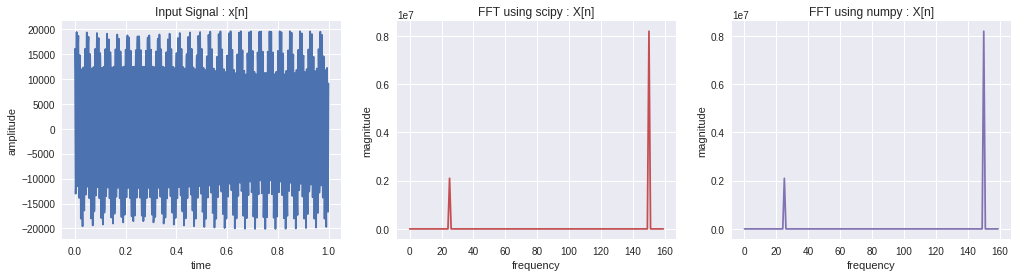

In [339]:
t = 1

x = sine(f=25, t=t) + cosine(A=16000, f=150, t=t)
X_sc = np.abs(fftpack.fft(x))
X_np = np.abs(np.fft.fft(x))

time = np.linspace(0, t, len(x))
freq = fftpack.fftfreq(x.size) * 1024 * t

print('Is X_sc equals X_np?', np.allclose(X_sc, X_np))
print()

fig = plt.figure(figsize=(17, 4))
plt.subplot(131)
plt.title('Input Signal : x[n]')
plt.plot(time, x)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.subplot(132)
plt.title('FFT using scipy : X[n]')
plt.plot(freq[:160], X_sc[:160], color='C2')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.subplot(133)
plt.title('FFT using numpy : X[n]')
plt.plot(freq[:160], X_np[:160], color='C3')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.show()

### Complex number

> "*Note that the FFT returns a complex spectrum that, in the case of real inputs, is conjugate symmetrical (i.e., symmetric in the real part and antisymmetric in the imaginary part)*" [Elegant SciPy](https://github.com/elegant-scipy/elegant-scipy/blob/master/markdown/ch4.markdown)

The above sentence is better viewed in the image bellow:

![title](https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/Complex_conjugate_picture.svg/300px-Complex_conjugate_picture.svg.png)

When plotting points using cosine and sine waves we generate a special caracteristics of complex number, named Unit Circle, that releates directly with Euler's Formula:

$e^{j\theta} = \cos{\theta} + j \sin{\theta}$

This is a trigonometric property directly releate with complex numbers.

Bellow is the example of **Unit Circle** build using only complex number and plotting in a complex plane.

First point (cos x sin) in the Unit Circle:
Magnitude:  1.0
Phase:      180.0


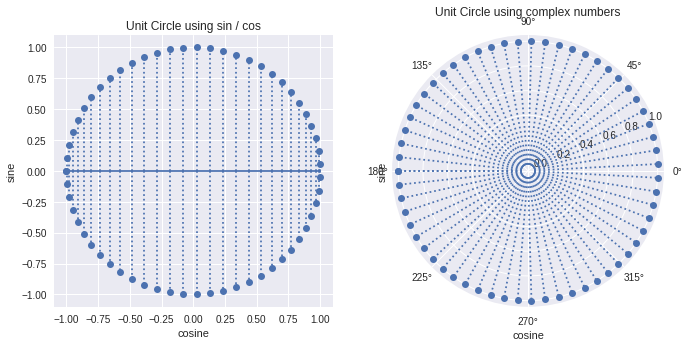

In [340]:
# Unit circle created using cos and sin
k = np.linspace(np.pi, -np.pi, 60)
sin = np.sin(k)
cos = np.cos(k)

print('First point (cos x sin) in the Unit Circle:')
print('Magnitude: ', np.sqrt(sin[0]**2 + cos[0]**2))
print('Phase:     ', np.degrees(np.arctan2(sin[0], cos[0])))

plt.figure(figsize=(11, 5))

plt.subplot(121)
plt.title('Unit Circle using sin / cos')
plt.stem(cos, sin, linefmt='C0:', markerfmt='C0o', basefmt='C0');
plt.xlabel('cosine')
plt.ylabel('sine')

# Unit circle created using complex numbers
plt.subplot(122, polar=True)
plt.title('Unit Circle using complex numbers')
cs = 1 + np.linspace(np.pi, -np.pi, 60) * 1j
for c in cs:
    plt.stem([c.imag], [c.real], linefmt='C0:', markerfmt='C0o', basefmt='C0')
plt.xlabel('cosine')
plt.ylabel('sine')
    
plt.show()

Let's join together both concept above, sine/cosine waves and complex number using Euler's Formula, creating complex sine waves using exponentials:

$me^{j2\pi ft}$.

Where: 

$m$ is magnitude of the wave

$f$ is the frequency and 

$t$ is time (in seconds).

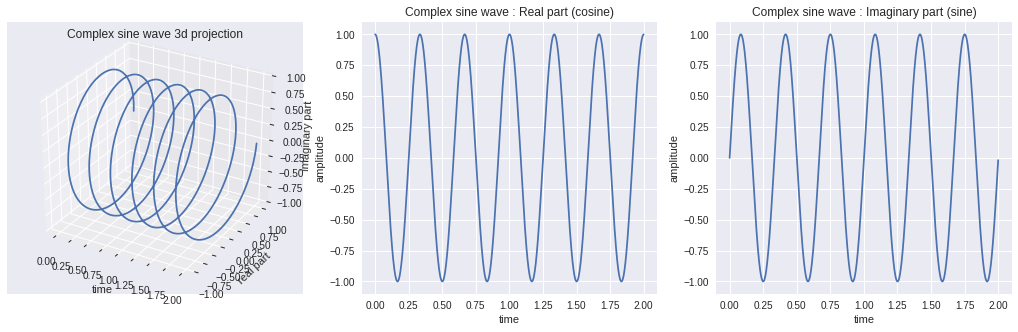

In [341]:
t = 2
csw = complex_wave(f=3, t=t)

time = np.linspace(0, t, len(csw))

fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(131, projection='3d')
plt.title('Complex sine wave 3d projection')
ax.plot(time, np.real(csw), np.imag(csw), zdir='z')
ax.set_xlabel('time')
ax.set_ylabel('real part')
ax.set_zlabel('imaginary part')

fig.add_subplot(132)
plt.title('Complex sine wave : Real part (cosine)')
plt.plot(time, np.real(csw))
plt.xlabel('time')
plt.ylabel('amplitude')

fig.add_subplot(133)
plt.title('Complex sine wave : Imaginary part (sine)')
plt.plot(time, np.imag(csw))
plt.xlabel('time')
plt.ylabel('amplitude')

plt.show()

The code bellow we prove the above setence, showing the values of an sinusoid with frequency of 1Hz and 10 samples. We extract each value of it's FFT and calculate the difference between it's real part and imaginary part.


In [342]:
x = sine(A=10, f=1, t=1, Fs=10)
X = fftpack.fft(x)

print(f'Input signal : x[n] : \n{x}\n')
print(f'FFT          : X[n] : \n{X}\n')

for i in range(1, len(X) // 2):
    print('-' * 10)
    print(f'{i} <=> {-i}')
    print(f'{X[i]} <=> {X[-i]}')
    print('Real part diff: ', X[i].real - X[-i].real)
    print('Imaginary part diff: ', X[i].imag + X[-i].imag)

# np.fft.fftfreq(x.size, d=.1)

Input signal : x[n] : 
[ 0  5  9  9  5  0 -5 -9 -9 -5]

FFT          : X[n] : 
[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00-4.59937396e+01j
 -9.43689571e-16-1.55431223e-15j  9.43689571e-16+2.13913876e+00j
  0.00000000e+00-3.55271368e-15j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+3.55271368e-15j  9.43689571e-16-2.13913876e+00j
 -9.43689571e-16+1.55431223e-15j  0.00000000e+00+4.59937396e+01j]

----------
1 <=> -1
-45.993739632474984j <=> 45.993739632474984j
Real part diff:  0.0
Imaginary part diff:  0.0
----------
2 <=> -2
(-9.43689570931383e-16-1.5543122344752192e-15j) <=> (-9.43689570931383e-16+1.5543122344752192e-15j)
Real part diff:  0.0
Imaginary part diff:  0.0
----------
3 <=> -3
(9.43689570931383e-16+2.1391387566259628j) <=> (9.43689570931383e-16-2.1391387566259628j)
Real part diff:  0.0
Imaginary part diff:  0.0
----------
4 <=> -4
-3.552713678800501e-15j <=> 3.552713678800501e-15j
Real part diff:  0.0
Imaginary part diff:  0.0


### Dot product

*"Algebraically, the dot product is the sum of the products of the corresponding entries of the two sequences of numbers. Geometrically, it is the product of the Euclidean magnitudes of the two vectors and the cosine of the angle between them."* [wiki](https://en.wikipedia.org/wiki/Dot_product)

#### Algebraic definition

The dot product of two vector is given by the following formula:

$a \cdot b = \Sigma^{n}_{i=1}a_ib_i = a_1b_1+a_2b_2+ ... a_nb_n$

#### Geometric definition 

$a \cdot b = \|a\| \|b\| \cos\theta$

If $a$ and $b$ are orthogonal (perpendicular : angle of 90º) then:

$a \cdot b = \|a\| \|b\| \cos\frac{\pi}{2} = \|a\|\|b\| 0$

See link of wikipedia to better undestand the relation of dot product and **geometric definition**.

-------------------------------------------

Bellow is a code explaning how to use the dot product in real and complex sine waves to calculate the frequencies inside a signal.

As an example we are using a **Morlet Wavelet**:

**Morlet Wavelet**: a sine wave that is "windowed" (i.e., multiplied point by point) by a Gaussian. 

Using this wavelet we extract the main frequency, using the dot product of a complex sine wave.

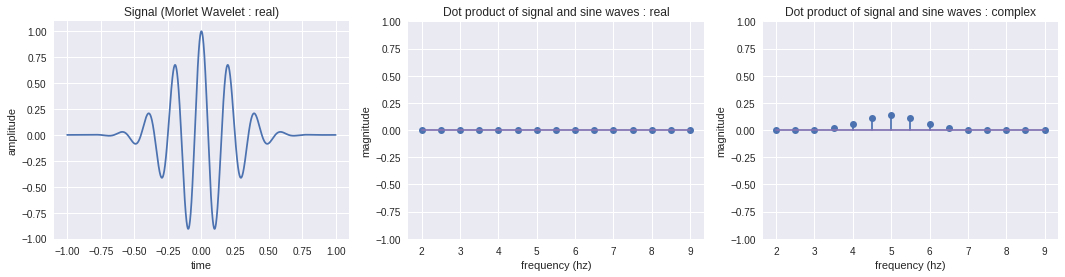

In [343]:
theta = 2*np.pi/4;
time = np.arange(-1, 1.001, .001)
freqs = np.arange(2, 9.1, .5)

signal = (np.sin(2 * np.pi * 5 * time + theta) * np.exp( (-time**2) / .1)).astype('float32')

dt_rg = np.zeros(freqs.size, dtype='float32')
dt_cx = np.zeros(freqs.size, dtype=np.complex64)
for i, freq in enumerate(freqs):
    sw_rg = (np.sin(2 * np.pi * freq * time)).astype('float32')
    dt_rg[i] = np.dot(sw_rg, signal) / len(time)
    sw_cx = (np.exp(-1j * 2 * np.pi * freq * time)).astype(np.complex64)
    dt_cx[i] = np.dot(sw_cx, signal) / len(time)

plt.figure(figsize=(18, 4))

plt.subplot(131)
plt.title('Signal (Morlet Wavelet : real)')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time, signal)

plt.subplot(132)
plt.title('Dot product of signal and sine waves : real')
plt.xlabel('frequency (hz)')
plt.ylabel('magnitude')
plt.stem(freqs, dt_rg)
plt.xticks(np.arange(2, 10, 1))
plt.yticks(np.arange(-1, 1.01, .25))

plt.subplot(133)
plt.title('Dot product of signal and sine waves : complex')
plt.xlabel('frequency (hz)')
plt.ylabel('magnitude')
plt.stem(freqs, np.abs(dt_cx))
plt.xticks(np.arange(2, 10, 1))
plt.yticks(np.arange(-1, 1.01, .25))

plt.show()

Bellow is two more examples... the first one we use the **FFT** package defined inside numpy to calculate the frequencies of a 3 sine wave joined together.

To normalize the magnitude showing in the FFT frequency graph we should divide the magniturde by the sampling interval.

$ mag = 2 |X| (\frac{1}{Fs \times t}) $

Or, one could simply divide by the number of points and multiple by 2:

$ mag = 2 \frac{|X|}{x.size} $

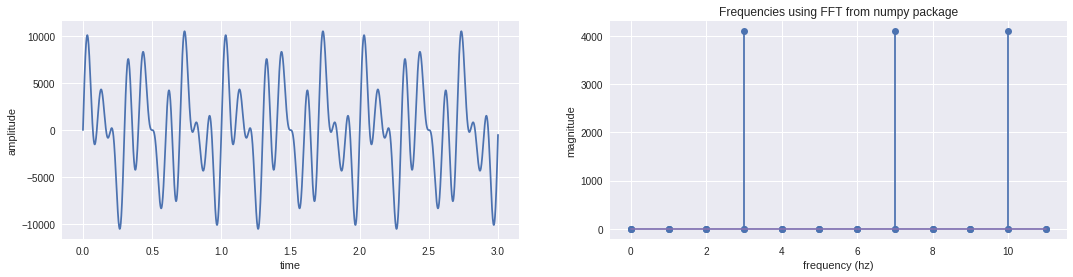

In [344]:
t = 3
time = np.linspace(0, t, 1024 * t)

x = sine(f=3, t=t) + sine(f=7, t=t) + sine(f=10, t=t)
X = fftpack.fft(x)

mag = 2 * np.abs(X) * (1 / (1024 * t)) # magnitude normalization

freqs = (fftpack.fftfreq(x.size) * 1024).astype('int32')

plt.figure(figsize=(18, 4))
plt.subplot(121)
plt.plot(time, x)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.subplot(122)
plt.title('Frequencies using FFT from numpy package')
plt.xlabel('frequency (hz)')
plt.ylabel('magnitude')
plt.stem(freqs[:35], mag[:35])
plt.show()

And now we calculate the same as above, but instead of using **FFT**, we calculate the same frequencies using complex sine waves and the dot product.

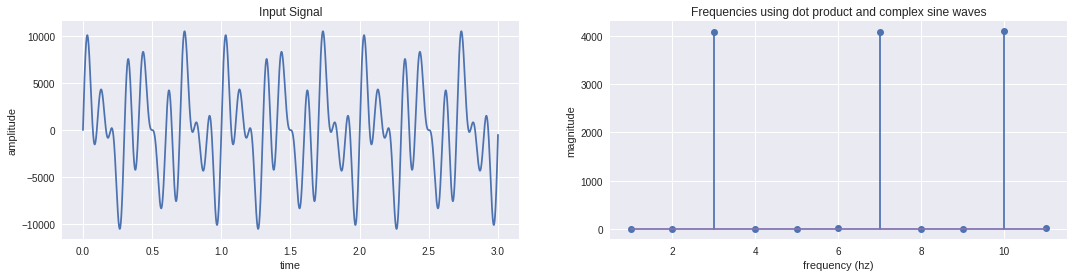

In [345]:
t = 3
time = np.linspace(0, t, 1024 * t)

signal = sine(f=3, t=t) + sine(f=7, t=t) + sine(f=10, t=t)

freqs = np.arange(1, 11.1, 1)
dt = np.zeros(freqs.size, dtype=np.complex64)
for i, freq in enumerate(freqs):
    sw = (np.exp(-1j * 2 * np.pi * freq * time)).astype(np.complex64)
    dt[i] = np.dot(sw, signal) / len(time)

plt.figure(figsize=(18, 4))

plt.subplot(121)
plt.title('Input Signal')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time, signal)

plt.subplot(122)
plt.title('Frequencies using dot product and complex sine waves')
plt.xlabel('frequency (hz)')
plt.ylabel('magnitude')
plt.stem(freqs, np.abs(dt) * 2)
plt.show()

### DFT Basis functions

*"The sine and cosine waves used in the DFT are commonly called the DFT basis functions. In other words, the output of the DFT is a set of numbers that represent amplitudes. The basis functions are a set of sine and cosine waves with unity amplitude. If you assign each amplitude (the frequency domain) to the proper sine or cosine wave (the basis functions), the result is a set of scaled sine and cosine waves that can be added to form the time domain signal.*

*...Since these sinusoids add to form the input signal, they must be the same length as the input signal.*" [dspguide.com](http://www.dspguide.com/ch8/4.htm)

**NOTE:** To demonstrate the sum of all sine and cosine waves to calculate the FFT, we use the example above and just plot each component wave.

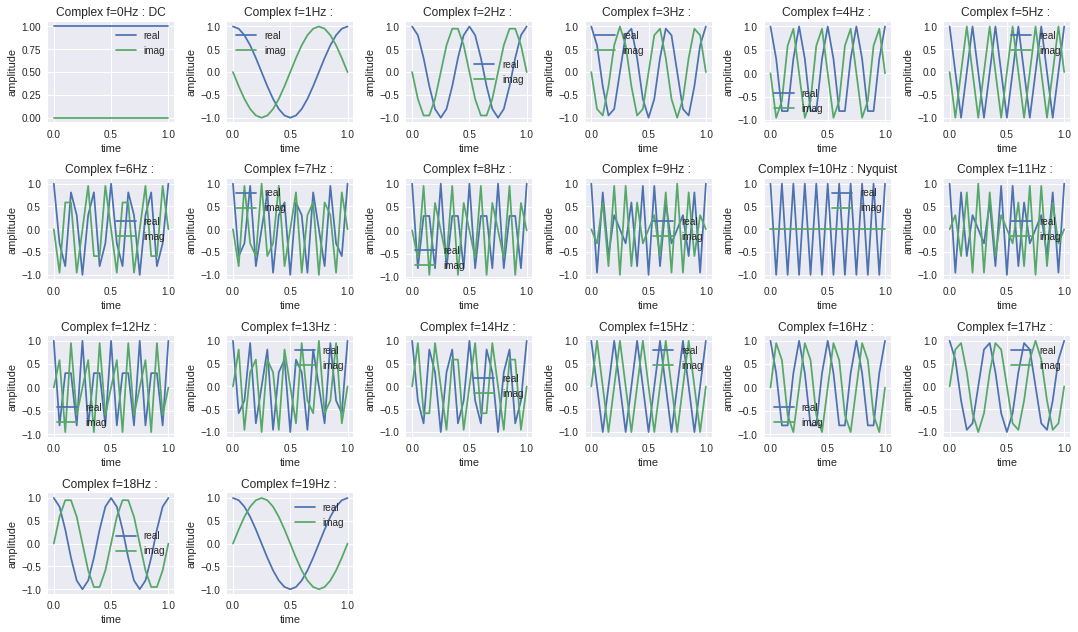

In [346]:
Fs = 21
t = 1
time = np.linspace(0, t, Fs * t)

freqs = []
for i, freq in enumerate(np.arange(0, (Fs-2)+.1, 1)):
    sw = (np.exp(-1j * 2 * np.pi * freq * time)).astype(np.complex64)
    freqs.append(sw)
freqs = np.array(freqs)

plt.figure(figsize=(15, 15))
for i, f in enumerate(freqs):
    r = np.real(f)
    im = np.imag(f)
    info = ''
    if i == 0:
        info = 'DC'
    # This nyquist string concatenation only works for even Fs number
    if i == int(Fs / 2):
        info = 'Nyquist'
    plt.subplot(7, 6, i+1)
    plt.title(f'Complex f={i}Hz : {info}')
    plt.xlabel('time')
    plt.ylabel('amplitude')
    plt.plot(time, r, label='real')
    plt.plot(time, im, label='imag')
    plt.legend()
plt.tight_layout()
plt.show()

**NOTE**: Complex sine and cosine waves above the last frequency show in graphs above will be aliasing of the original frequency.

### DC Component:

> "*When describing a periodic function in the time domain, the DC bias, **DC component**, DC offset, or DC coefficient is the mean amplitude of the waveform. If the mean amplitude is zero, there is no DC bias. A waveform with no DC bias is known as a DC balanced or DC free waveform.*" [wiki](https://en.wikipedia.org/wiki/DC_bias)

> "*The **DC term is the 0 Hz term** and is equivalent to the average of all the samples in the window (hence it's always purely real for a real signal). The terminology does indeed come from AC/DC electricity - all the non-zero bins correspond to non-zero frequencies, i.e. "AC components" in an electrical context, whereas the zero bin corresponds to a fixed value, the mean of the signal, or "DC component" in electrical terms. **As far as practical applications go, the DC or 0 Hz term is not particularly useful. In many cases it will be close to zero, as most signal processing applications will tend to filter out any DC component at the analogue level**. In cases where you might be interested it can be calculated directly as an average in the usual way, without resorting to a DFT/FFT.*" [dsp.stackexchange](https://dsp.stackexchange.com/questions/12972/discrete-fourier-transform-what-is-the-dc-term-really)

> "*DC component just means the average of positive and negative half cycles is not zero. There is an offset. The reason maybe that  the signal is 'biased' by adding a DC signal.*" [Quora](http://qr.ae/TUIR55)

Bellow we show an example of the DC Component.

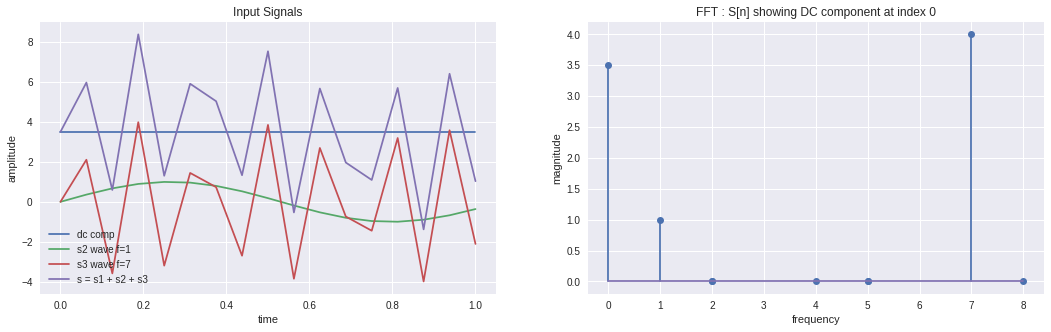

In [347]:
t = 1
f = 7
# Nyquist limit f * 2 limit.
# Since the biggest frequency is 10, Nyquist forces us to have 10 * 2 sample points.
# Nyquist Rate: f > 1/2 * Fs
Fs = (f * 2) + (f // 2)
# Let's define de DC Component
dc_comp = np.zeros(Fs * t)
dc_comp[:] = 3.5
time = np.linspace(0, t, Fs * t)

# Signal
s1 = dc_comp
s2 = sine(A=1, f=1, t=t, Fs=Fs, dtype=np.float32)
s3 = sine(A=4, f=f, t=t, Fs=Fs, dtype=np.float32)
s = s1 + s2 + s3
# Fourier!
S = fftpack.fft(s)

# Generate frequencies values...
freqs = (fftpack.fftfreq(s.size) * Fs).astype('int32')
# Let's show only the positive frequency
fim = max(freqs) + 1
freqs = freqs[:fim]

# Normalize the FFT, so magnitude is equal to amplitude value
rFreq = (np.abs(S) / len(s))[:fim]
# we should not normalize the DC component, otherwise it's value will be wrong
rFreq[1:] = rFreq[1:] * 2

# plot
fig = plt.figure(figsize=(18, 5))
plt.subplot(121)
plt.title('Input Signals')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time, s1, label='dc comp')
plt.plot(time, s2, label='s2 wave f=1')
plt.plot(time, s3, label=f's3 wave f={f}')
plt.plot(time, s, label='s = s1 + s2 + s3')
plt.legend()
plt.subplot(122)
plt.title('FFT : S[n] showing DC component at index 0')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs, rFreq)
plt.show()

### Polar Representation

*"In mathematics, the polar coordinate system is a two-dimensional coordinate system in which each point on a plane is determined by a distance from a reference point and an angle from a reference direction.* 

*The polar coordinates $r$ and $\ro$ can be converted to the Cartesian coordinates $x$ and $y$ by using the trigonometric functions sine and cosine: *" [wiki](https://en.wikipedia.org/wiki/Polar_coordinate_system)

$ x = r \cos \phi $

$ y = r \sin \phi $

And the inverse can be accomplished using:

$ r = \sqrt{x^2 + y^2} $

$ \phi = atan2(y, x) $

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/Polar_to_cartesian.svg/429px-Polar_to_cartesian.svg.png" width="200" />

Using matplotlib is easy to see this transformation just using the polar representation.

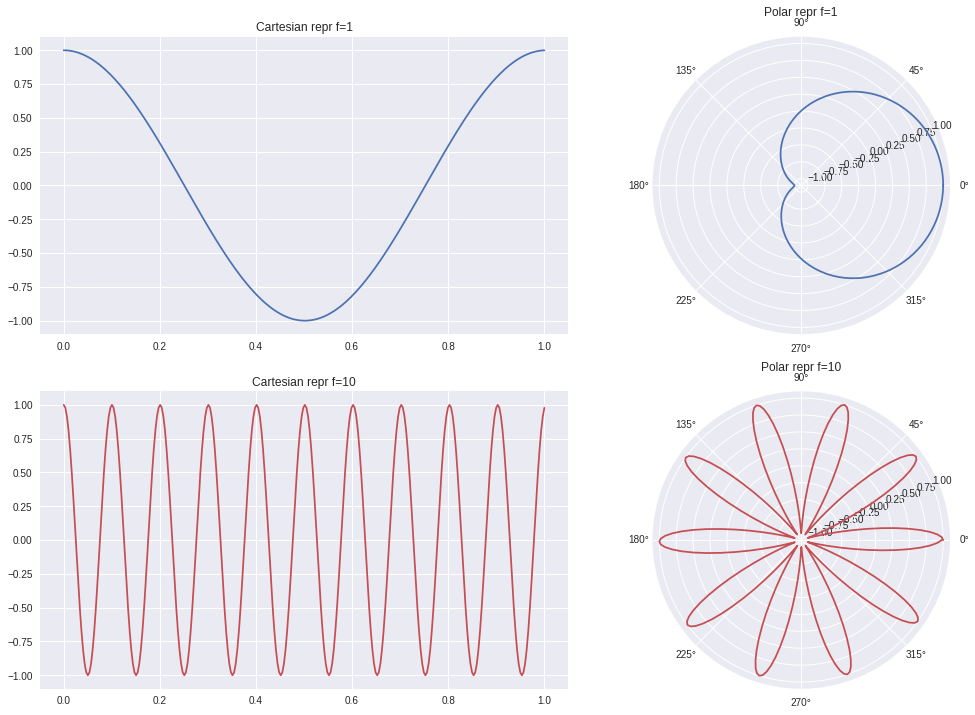

In [348]:
t = 1
f = 1
Fs = ((f * 2) + (f // 2)) * 150
time = np.linspace(0, t, Fs * t)
x = sine(A=1, f=f, t=t, Fs=Fs, phi=np.pi/2, dtype=np.float32)
x2 = sine(A=1, f=10, t=t, Fs=Fs, phi=np.pi/2, dtype=np.float32)

plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.title('Cartesian repr f=1')
plt.plot(time, x)
sp = plt.subplot(222, polar=True)
plt.title('Polar repr f=1')
plt.plot(np.linspace(0, 2*np.pi, Fs * t), x)
plt.subplot(223)
plt.title('Cartesian repr f=10')
plt.plot(time, x2, color='C2')
sp = plt.subplot(224, polar=True)
plt.title('Polar repr f=10')
plt.plot(np.linspace(0, 2*np.pi, Fs * t), x2, color='C2')
plt.tight_layout()
plt.show()

## Inverse Fourier Transform

As shown above, the formula to compute the Inverse Fourier Transform is:

$ x_n=\frac{1}{N}\sum_{k=0}^{N−1}X_ke^{j 2\pi k n / N} $

Input Signal and IFFT result equals?  True
Diff? Dot product :  (0.6437406510494288+0.000818366075236554j)
Diff? Dot x scipy :  (0.643740649252095+0.000818366075236554j)


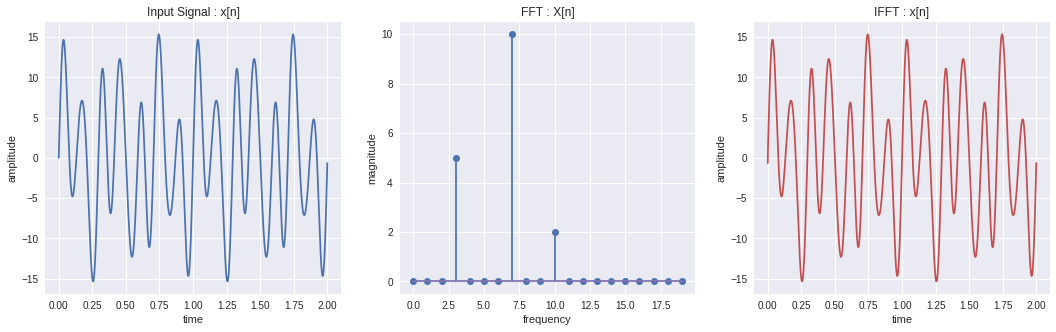

In [349]:
def fft(x, t):
    size = x.size
    time = np.linspace(0, t, size)
    freqs = (fftpack.fftfreq(size) * size).astype('int32')
    dt = np.zeros(freqs.size, dtype=np.complex64)
    for i, freq in enumerate(freqs):
        sw = (np.exp(-1j * 2 * np.pi * freq * time)).astype(np.complex64)
        dt[i] = np.dot(sw, x) / len(time)
    # Normalize the FFT, so magnitude is equal to amplitude value
    rFreq = np.abs(dt)
    # we should not normalize the DC component, otherwise it's value will be wrong
    rFreq[1:] = rFreq[1:] * 2
    return dt, time, freqs, rFreq

def ifft(X, t):
    size = X.size
    time = np.linspace(0, t, size)
    reconSignal = np.zeros(size);
    freqs = (fftpack.fftfreq(size) * size).astype('int32')
    for i, freq in enumerate(freqs):
        csw = X[freq] * (np.exp(1j * 2 * np.pi * freq * time)).astype(np.complex64)
        reconSignal = reconSignal + csw;
    return reconSignal

t = 2
x = sine(A=5, f=3, t=t, dtype=np.float64) + \
     sine(A=10, f=7, t=t, dtype=np.float64) + \
     sine(A=2, f=10, t=t, dtype=np.float64)
X, time, freqs, rFreq = fft(x, t)
rx = ifft(X, t)

print('Input Signal and IFFT result equals? ', (x - rx).all())
print('Diff? Dot product : ', sum(x - rx))
print('Diff? Dot x scipy : ', sum(fftpack.ifft(X) - rx))

# plot
fig = plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.title('Input Signal : x[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time, x)
plt.subplot(132)
plt.title('FFT : X[n]')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs[:20], rFreq[:20])
plt.subplot(133)
plt.title('IFFT : x[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time, rx.real, color='C2')
plt.show()

#### Band-stop filtering using IFFT

The bellow code presents how to remove a frequency from a signal using the FFT and IFFT. The simplicity of the code should not be use in pratical uses because of the extreme reduction in the frequency, instead one could use a more gently reduction using [Dimensionality Reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction).

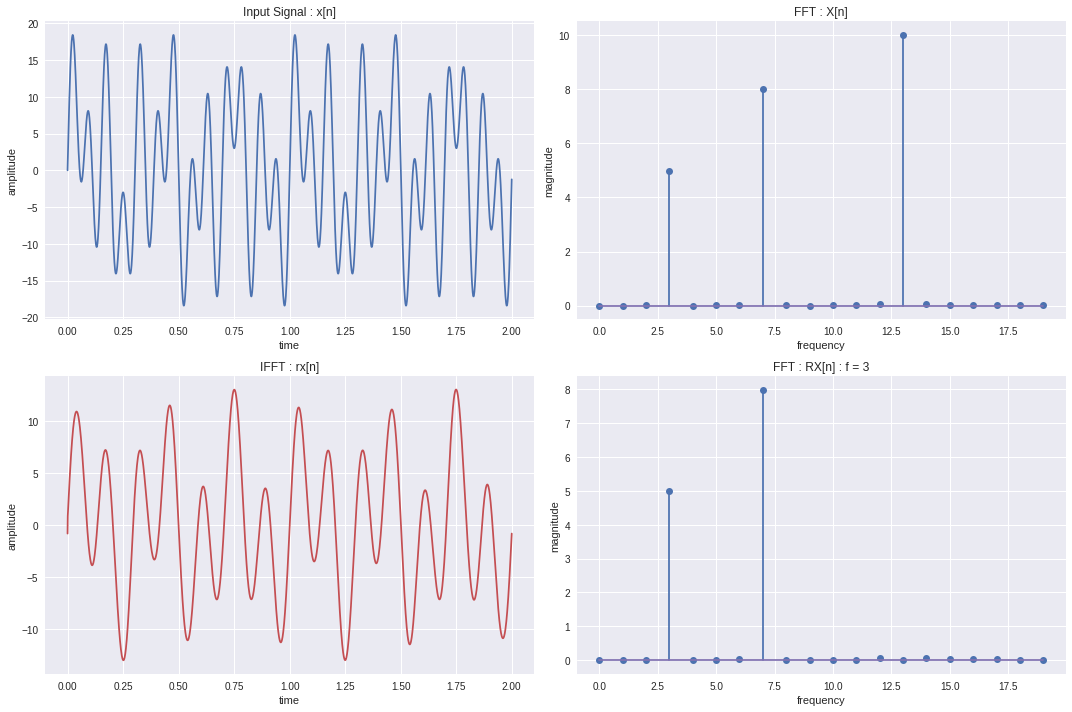

In [350]:
t = 2
x = sine(A=5, f=3, t=t, dtype=np.float64) + \
    sine(A=10, f=13, t=t, dtype=np.float64) + \
    sine(A=8, f=7, t=t, dtype=np.float64)
X, time, freqs, rFreq = fft(x, t)

# filtering
idx = np.where(np.abs(X) * 2 > 8.99)
X[idx] = 0.0

# inverse of filtered X
rx = ifft(X, t)
RX, t, f, rF = fft(rx, t)

# plot
fig = plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.title('Input Signal : x[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time, x)
plt.subplot(222)
plt.title('FFT : X[n]')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(freqs[:20], rFreq[:20])
plt.subplot(223)
plt.title('IFFT : rx[n]')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(time, rx.real, color='C2')
plt.subplot(224)
plt.title('FFT : RX[n] : f = 3')
plt.xlabel('frequency')
plt.ylabel('magnitude')
plt.stem(f[:20], rF[:20])
plt.tight_layout()
plt.show()

In [351]:
t = 2
x = sine(A=5, f=3, t=t, dtype=np.float64) + \
    sine(A=10, f=13, t=t, dtype=np.float64) + \
    sine(A=8, f=7, t=t, dtype=np.float64)

%time fft(x, t)
%time fftpack.fft(x)

CPU times: user 308 ms, sys: 2.3 ms, total: 310 ms
Wall time: 311 ms
CPU times: user 137 µs, sys: 0 ns, total: 137 µs
Wall time: 131 µs


array([-8.28302275e-14+0.00000000e+00j, -2.35048121e-13-5.62336049e-14j,
       -3.75021804e-13-1.67237474e-14j, ...,
        1.72455320e-13-4.97885455e-13j, -3.75021804e-13+1.67237474e-14j,
       -2.35048121e-13+5.62336049e-14j])